# Image matching example with new kornia local features: TFeat, MKD, OriNet

First, we will install everything needed:

Installing the and pydegensac for good RANSAC

*  fresh version of [kornia](https://github.com/kornia/kornia) for [MKD](https://arxiv.org/pdf/1707.07825.pdf) and [TFeat](http://www.bmva.org/bmvc/2016/papers/paper119/paper119.pdf) descriptors
*  fresh version of OpenCV for SIFT features
*  [kornia_moons](https://ducha-aiki.github.io/kornia_moons) for the conversions between OpenCV and kornia formats
*  [pydegensac](https://github.com/ducha-aiki/pydegensac) for the robust epipolar geometry estimation


In [ ]:
!pip install git+https://github.com/kornia/kornia
!pip install pydegensac
!pip install kornia_moons
!pip install opencv-python --upgrade

Now let's download an image pair


In [ ]:
# Download image pair
!wget https://github.com/kornia/kornia-examples/raw/master/data/matching/kn_church-2.jpg
!wget https://github.com/kornia/kornia-examples/raw/master/data/matching/kn_church-8.jpg


First, we will define image matching pipeline with OpenCV SIFT features. We will also use kornia for the state-of-the-art match filtering -- Lowe ratio + mutual nearest neighbor check and Pydegensac as RANSAC

In [1]:
import matplotlib.pyplot as plt
import cv2
import kornia as K
import kornia.feature as KF
import numpy as np
import torch
import pydegensac
from kornia_moons.feature import *

def sift_matching(fname1, fname2):
  img1 = cv2.cvtColor(cv2.imread(fname1), cv2.COLOR_BGR2RGB)
  img2 = cv2.cvtColor(cv2.imread(fname2), cv2.COLOR_BGR2RGB)
  
  sift = cv2.SIFT_create(8000)
  kps1, descs1 = sift.detectAndCompute(img1, None)
  kps2, descs2 = sift.detectAndCompute(img2, None)
  dists, idxs = KF.match_smnn(torch.from_numpy(descs1), torch.from_numpy(descs2), 0.95)
  tentatives = cv2_matches_from_kornia(dists, idxs)
  src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
  dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
  F, inliers_mask = pydegensac.findFundamentalMatrix(src_pts, dst_pts, 0.75, 0.99, 100000)
  draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = inliers_mask.ravel().tolist(), # draw only inliers
                   flags = 2)
  img_out = cv2.drawMatches(img1,kps1,img2,kps2,tentatives,None,**draw_params)
  plt.figure()
  fig, ax = plt.subplots(figsize=(15, 15))
  ax.imshow(img_out, interpolation='nearest')
  print (f'{inliers_mask.sum()} inliers found')
  return   



18 inliers found


<Figure size 432x288 with 0 Axes>

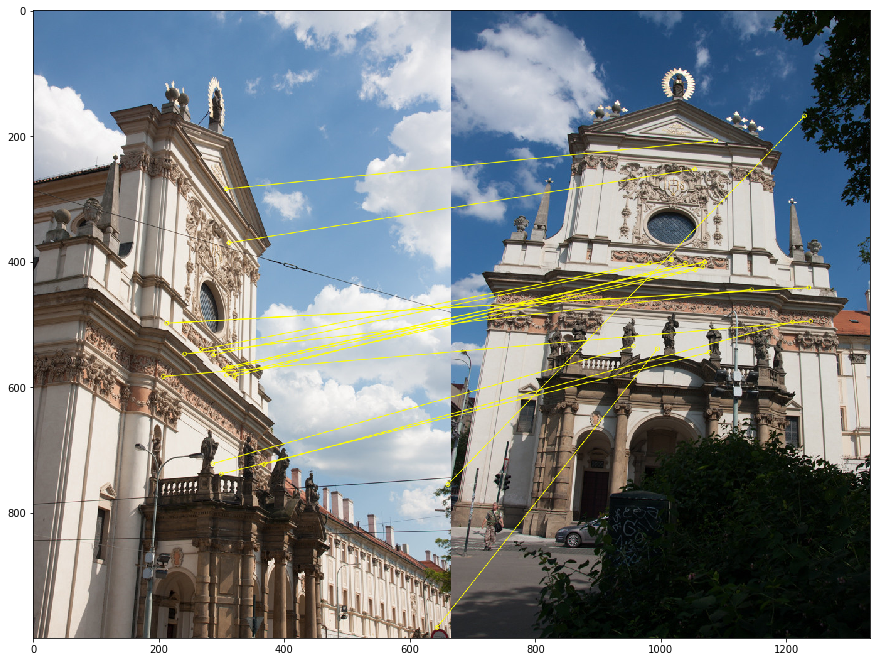

In [2]:
fname1 = 'kn_church-2.jpg'
fname2 = 'kn_church-8.jpg'
sift_matching(fname1, fname2)

Now we need to define a function to feed the OpenCV keypoints into local descriptors from kornia. Luckily, that is easy with the help of kornia_moons.

In [3]:
def get_local_descriptors(img, cv2_sift_kpts, kornia_descriptor):
  if len(cv2_sift_kpts)==0:
    return np.array([])
  
  #We will not train anything, so let's save time and memory by no_grad()
  with torch.no_grad():
    kornia_descriptor.eval()
    timg = K.color.rgb_to_grayscale(K.image_to_tensor(img, False))/255.
    lafs = laf_from_opencv_SIFT_kpts(cv2_sift_kpts)
    patches = KF.extract_patches_from_pyramid(timg,lafs, 32)
    B, N, CH, H, W = patches.size()
    # Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
    # So we need to reshape a bit :) 
    descs = kornia_descriptor(patches.view(B * N, CH, H, W)).view(B * N, -1)
  return descs.detach().cpu().numpy()

def sift_korniadesc_matching(fname1, fname2, descriptor):
  img1 = cv2.cvtColor(cv2.imread(fname1), cv2.COLOR_BGR2RGB)
  img2 = cv2.cvtColor(cv2.imread(fname2), cv2.COLOR_BGR2RGB)
  
  sift = cv2.SIFT_create(8000)
  kps1 = sift.detect(img1, None)
  kps2 = sift.detect(img2, None)
  # That is the only change in the pipeline -- descriptors
  descs1 = get_local_descriptors(img1, kps1, descriptor)
  descs2 = get_local_descriptors(img2, kps2, descriptor)
  # The rest is the same, as for SIFT

  dists, idxs = KF.match_smnn(torch.from_numpy(descs1), torch.from_numpy(descs2), 0.95)
  tentatives = cv2_matches_from_kornia(dists, idxs)
  src_pts = np.float32([ kps1[m.queryIdx].pt for m in tentatives ]).reshape(-1,2)
  dst_pts = np.float32([ kps2[m.trainIdx].pt for m in tentatives ]).reshape(-1,2)
  F, inliers_mask = pydegensac.findFundamentalMatrix(src_pts, dst_pts, 0.75, 0.99, 100000)
  draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = inliers_mask.ravel().tolist(), # draw only inliers
                   flags = 2)
  img_out = cv2.drawMatches(img1,kps1,img2,kps2,tentatives,None,**draw_params)
  plt.figure()
  fig, ax = plt.subplots(figsize=(15, 15))
  ax.imshow(img_out, interpolation='nearest')
  print (f'{inliers_mask.sum()} inliers found')

Now let's try kornia new descriptors -- MKD and TFeat. 
MKD is one of the best handcrafted local feature descriptors, presented in IJCV 2018 paper "[Understanding and Improving Kernel Local Descriptors](https://arxiv.org/abs/1811.11147)".


31 inliers found


<Figure size 432x288 with 0 Axes>

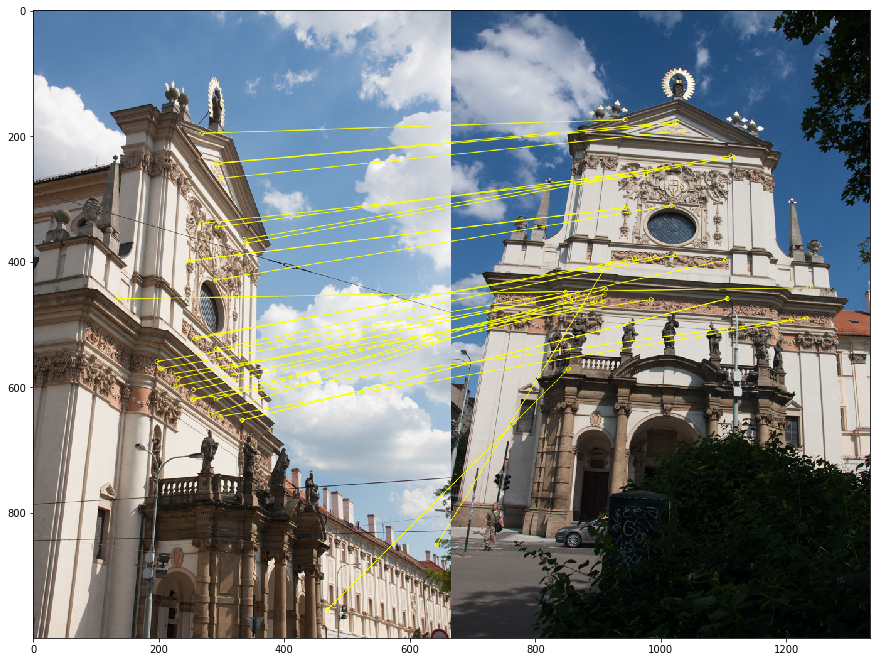

In [4]:
mkd = KF.MKDDescriptor(32)
sift_korniadesc_matching(fname1, fname2, mkd)

Result seems cleaner than with SIFTs. Let's try TFeat - lightweight deep learning-based descriptor from BMVC 2016 paper "[Learning local feature descriptors with triplets and shallow convolutional neural networks](http://www.bmva.org/bmvc/2016/papers/paper119/paper119.pdf)"

35 inliers found


<Figure size 432x288 with 0 Axes>

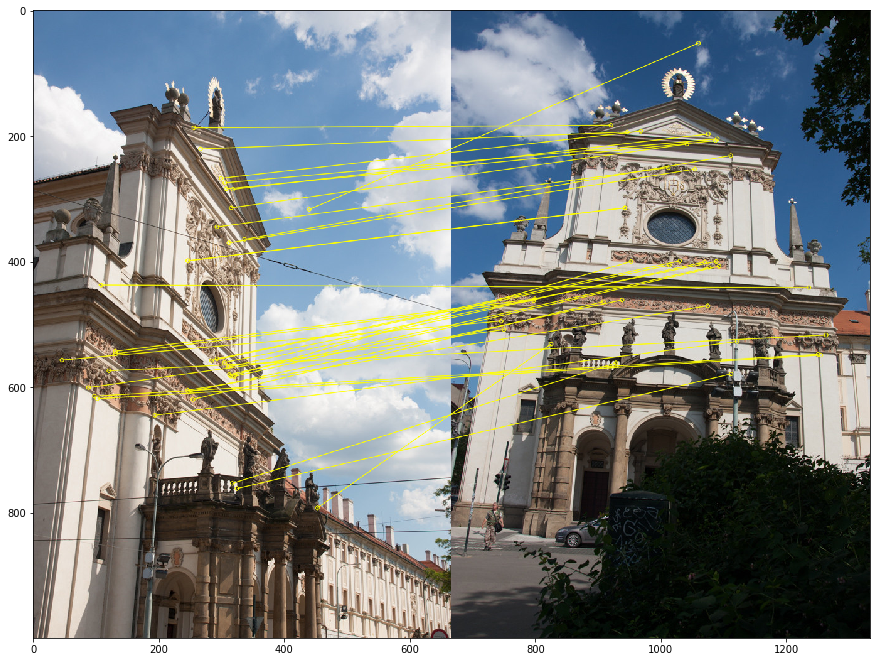

In [5]:
tfeat = KF.TFeat(True)
sift_korniadesc_matching(fname1, fname2, tfeat)

In the worst-case we can always fall back to the HardNet -- more robust, but also slower than TFeat and MKD, descriptor

55 inliers found


<Figure size 432x288 with 0 Axes>

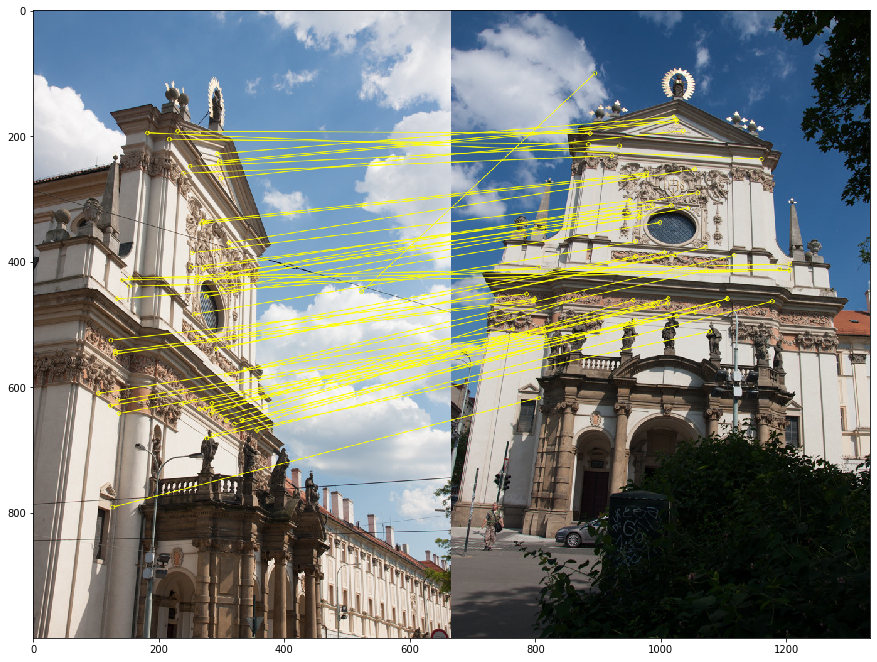

In [6]:
hardnet = KF.HardNet(True)
sift_korniadesc_matching(fname1, fname2, hardnet)

We haven't done yet! SIFT detector is a great tool, but we can improve it by using deep learned affine shape estimation -- [AffNet](https://arxiv.org/abs/1711.06704) recently added to kornia. We will update `get_local_descriptors` function to make use of the affine shape.


In [14]:
def get_local_descriptors(img, cv2_sift_kpts, kornia_descriptor):
  #We will not train anything, so let's save time and memory by no_grad()
  with torch.no_grad():
    kornia_descriptor.eval()
    timg = K.color.rgb_to_grayscale(K.image_to_tensor(img, False))/255.
    lafs = laf_from_opencv_SIFT_kpts(cv2_sift_kpts)
    # We will estimate affine shape of the feature and re-orient the keypoints with the OriNet
    affine = KF.LAFAffNetShapeEstimator(True)
    orienter = KF.LAFOrienter(32, angle_detector=KF.OriNet(True))
    orienter.eval()
    affine.eval()
    lafs_new = orienter(affine(lafs,timg), timg)
    patches = KF.extract_patches_from_pyramid(timg,lafs_new, 32)
    B, N, CH, H, W = patches.size()
    # Descriptor accepts standard tensor [B, CH, H, W], while patches are [B, N, CH, H, W] shape
    # So we need to reshape a bit :) 
    descs = kornia_descriptor(patches.view(B * N, CH, H, W)).view(B * N, -1)
  return descs.detach().cpu().numpy()

43 inliers found


<Figure size 432x288 with 0 Axes>

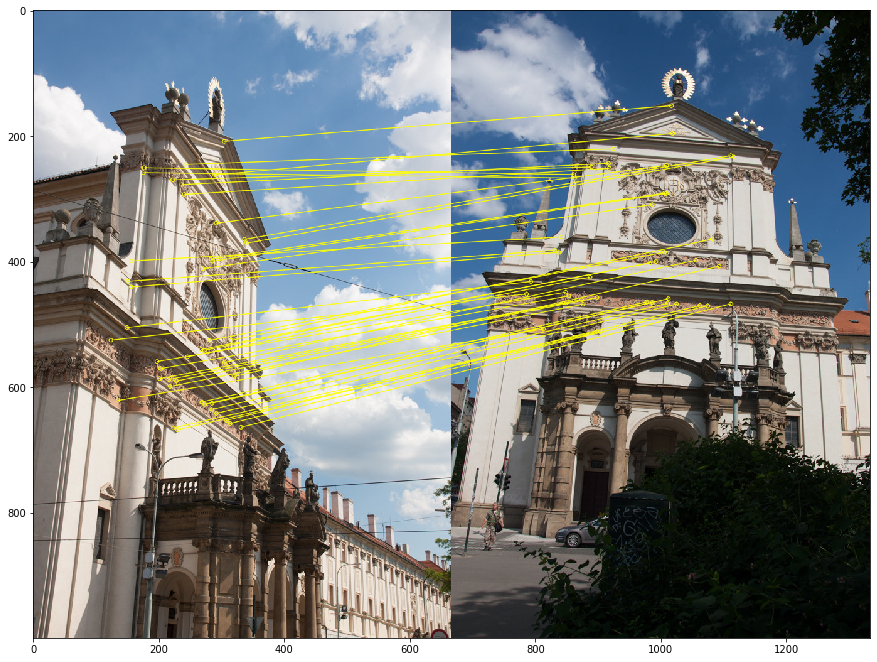

In [16]:
sift_korniadesc_matching(fname1, fname2, hardnet)